In [8]:
#Import required packages
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
#Insert filepath for local files  FOR THIBAUT
basepath = r"C:\Users\Thibaut Goldsborough\Documents\Seth_BoneMarrow\Data\BoneMarrow_unstained4"
readpath = basepath + "\\Raw_Images"
outpath = basepath + "\\Outputs"
file_prefix="\\unstained_"

num_images=10000

image_dim=64 #Dim of the final images

nuclear_channel="Ch7"
cellmask_channel="Ch1_mask"

In [10]:
#Insert filepath for local files  FOR THIBAUT
basepath = r"C:\Users\Thibaut Goldsborough\Documents\Seth_BoneMarrow\Data\BoneMarrow_smallerfile2"
readpath = basepath + "\\Raw_Images"
outpath = basepath + "\\Outputs"
file_prefix="\\smaller_file2_"

num_images=10000

image_dim=64 #Dim of the final images

nuclear_channel="Ch7"
cellmask_channel="Ch1_mask"

In [11]:
#Insert filepath for local files  FOR THIBAUT
basepath = r"C:\Users\Thibaut Goldsborough\Documents\Seth_BoneMarrow\Data\BoneMarrow_sample1"
readpath = basepath + "\\Raw_Images"
outpath = basepath + "\\Outputs"
file_prefix="\\sample1_"

num_images=10000

image_dim=64 #Dim of the final images

nuclear_channel="Ch7"
cellmask_channel="Ch1_mask"

In [12]:
#Read in images
names=[]
for entry in os.listdir(readpath): #Read all photos
    if os.path.isfile(os.path.join(readpath, entry)):
        names.append(entry)
       # if len(names)>=num_images*3:
        #    break

channel_names=[channel_name[:-8] for channel_name in np.unique([name.split("_")[file_prefix.count("_")+1] for name in names])] 

print("Found",len(channel_names),"channels")
print(channel_names)

data_dict={}
for name in names:
    cell_num=name.split("_")[file_prefix.count("_")]
    if cell_num not in data_dict.keys():
        data_dict[cell_num]=[cv.imread(readpath+file_prefix+cell_num+'_'+channel_name+'.ome.tif',0  | cv.IMREAD_ANYDEPTH) for channel_name in channel_names]

#13s

KeyboardInterrupt: 

In [32]:
BUGS=[]
for image in data_dict:
    for i in data_dict[image]:
      #  print(i)
        try: 
            if i==None:
                BUGS.append(image)
        except:
            pass

In [33]:
[data_dict.pop(BUG) for BUG in BUGS]

[]

In [34]:
#Rescale OME images to tiff
max_mins=[[0,1e6] for _ in channel_names]
for image_i in data_dict:
    image=data_dict[image_i]
    for i,_ in enumerate(max_mins):
        if max_mins[i][0]<np.max(image[i]):
            max_mins[i][0]=np.max(image[i])
        if max_mins[i][1]>np.min(image[i]):
            max_mins[i][1]=np.min(image[i])
print("Maximum and minimums of every raw channel")
print(max_mins)

Maximum and minimums of every raw channel
[[3272, 77], [2686, 0], [1847, 0], [2334, 0], [4090, 16], [4075, 0], [3804, 91]]


In [ ]:
#del data_dict[image_i] Use in case of nonetype error

In [35]:
def scale(img,max_min):
    return ((img-max_min[1])/(max_min[0]-max_min[1])*255)#.astype(np.uint8)

image_dict={} 
maskpath=basepath+"\\ExportedMasks"
for image_i in data_dict:
    images=data_dict[image_i]  

    processed_images=[]
    for i,image in enumerate(images):
        processed_images.append(scale(image,max_mins[i]))  #Rescale the images

    for channel in channel_names:
        processed_images.append(cv.imread(maskpath+file_prefix+image_i+'_'+channel+'.dmask.pgm',0 ))  # mask for channel

    image_dict[image_i]=processed_images

print("Order of the channels:")
channel_order=channel_names+[channel+'_mask' for channel in channel_names]
print(channel_order)


#This took 3 mins for 10,000 images and 7 channels

Order of the channels:
['Ch1', 'Ch11', 'Ch2', 'Ch3', 'Ch6', 'Ch7', 'Ch9', 'Ch1_mask', 'Ch11_mask', 'Ch2_mask', 'Ch3_mask', 'Ch6_mask', 'Ch7_mask', 'Ch9_mask']


In [36]:
#Create dataframe of image shape information
shape_dict = {'image':[], 'x':[], 'y':[], 'ratio':[]}
shape_df = pd.DataFrame(shape_dict)
for image_i in image_dict:
    image = image_dict[image_i]
    x, y = image[0].shape
    ratio = x/y
    shape_df = shape_df.append({'image':image_i, 'x':x, 'y':y, 'ratio':ratio}, ignore_index=True)

Average width of image:  64.0  Min:  44.0  Max:  169.0
Average height of image:  55.0  Min:  24.0  Max:  115.0


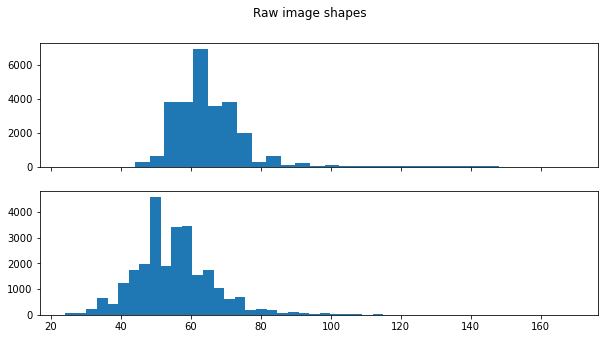

In [37]:
#Investigate sizes of images
print('Average width of image: ', np.round(shape_df.x.mean(), 0), ' Min: ', shape_df.x.min(), ' Max: ', shape_df.x.max())
print('Average height of image: ', np.round(shape_df.y.mean(), 0), ' Min: ', shape_df.y.min(), ' Max: ', shape_df.y.max())
fig, axs = plt.subplots(2, sharex=True, figsize=(10, 5))
fig.suptitle('Raw image shapes')
numbins = 30
axs[0].hist(shape_df.x, bins=numbins);
axs[1].hist(shape_df.y, bins=numbins);
plt.savefig(basepath+"\\dimension_hist.png")

In [38]:
df=pd.DataFrame()
df['Cell_ID']=image_dict.keys()

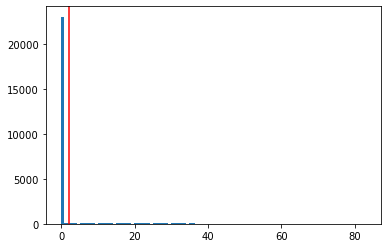

In [39]:
def Touches_Boundary(data_dict,channel_order,cellmask_channel,threshold=2):
    i=channel_order.index(cellmask_channel)
    touches=[]
    touch_val=[]
    for image_i in data_dict:
        image=data_dict[image_i][i].copy()
        image[1:-1,1:-1]=0  
        edge_pos=np.count_nonzero(image) 
        touch_val.append(edge_pos)
        if touch_val[-1]>threshold:
            touches.append(1)
        else:
            touches.append(0)

    plt.hist(touch_val,bins=100);
    plt.axvline(x=threshold,color="red")
    plt.show()

    return touches


df["Touches_boundary"]=Touches_Boundary(image_dict,channel_order,cellmask_channel,threshold=2)


In [40]:
#This sets all the backgrounds to 0

for channel in channel_names:
    channel_index=channel_order.index(channel)
    cellmask_index=channel_order.index(channel+'_mask')

    for image in image_dict:
        mean=np.mean(image_dict[image][channel_index][image_dict[image][cellmask_index]==0])
        image_dict[image][channel_index]-=(mean)

final_images=image_dict.copy()

In [41]:
#Pad images to squares
maxi=shape_df.x.max()
mini=shape_df.x.min()

def g(x):
    return 1/(np.log(x))**10

def f(x):
    return (g(x)-g(maxi))*(image_dim-mini)/(g(mini)-g(maxi))

def r(x):
    return int(round(x,0))

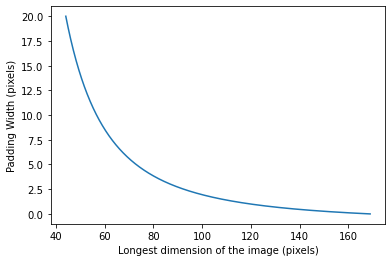

In [42]:
X=np.linspace(mini,maxi,num=1000)
plt.plot(X,f(X))
#plt.plot(X,X+f(X),color="red")
plt.xlabel("Longest dimension of the image (pixels)")
plt.ylabel("Padding Width (pixels)");
plt.savefig(basepath+"\\dimension_padding.png")

In [43]:
for image_i in final_images:
    images = final_images[image_i]
    x = np.shape(final_images[image_i][0])[0]
    y = np.shape(final_images[image_i][0])[1]

    if y>x:
        height=f(y)
        width=(y+height-x)
    else:
        width=f(x)
        height=(x+width-y)

    for i,image in enumerate(images):
        padded_img=cv.copyMakeBorder(image, r(width/2), r(width/2), r(height/2), r(height/2), cv.BORDER_CONSTANT)
        resized_img=cv.resize(padded_img,(image_dim,image_dim))
        final_images[image_i][i]=resized_img

#36 secs for 10,000 images

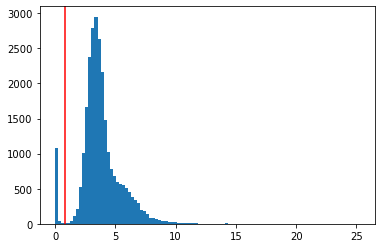

In [44]:
def DNA_POS(data_dict,channel_order,nuclear_channel,threshold=0.8):
    i=channel_order.index(nuclear_channel)
    dna_pos=[]
    mean_nuc=[]
    for image_i in data_dict:
        image=data_dict[image_i][i]
        mean_nuc.append(np.mean(image))
        if mean_nuc[-1]>=threshold:
            dna_pos.append(1)
        else:
            dna_pos.append(0)

    plt.hist(mean_nuc,bins=100);
    plt.axvline(x=threshold,color="red")
    plt.show()
            
    return dna_pos

df["DNA_pos"]=DNA_POS(final_images,channel_order,nuclear_channel,threshold=0.8)


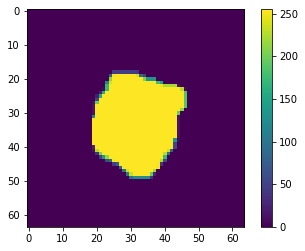

In [45]:
plt.imshow(image_dict['100'][channel_order.index(cellmask_channel)])
plt.colorbar()

In [47]:
posx,posy=[],[]

for coi,coi_str in enumerate(channel_order):  #coi is channel of interest
    print("Saving "+coi_str+"...")
    display_ims=[]
    names=[]
    for image_i in final_images:
        images = final_images[image_i]
        display_ims.append(images[coi])
        names.append(image_i)

    n=100  #x axis of final image or array 

    posx,posy=[],[]
    l=num_images//n
    for i in range(l):
        for j in range(n):
            posx.append(i)
            posy.append(j)
            if j==0:
                col_array=display_ims[i*n]
            else:
                col_array=np.hstack((col_array,display_ims[i*n+j]))

        if i==0:
            row_array=col_array
        else:
            row_array=np.vstack((row_array,col_array))

    myfig=plt.figure(dpi=2000)     
    plt.imshow(row_array-np.min(row_array),vmin=0,vmax=70,cmap="Greys")
    plt.axis('off')
    plt.savefig(outpath+"\\"+coi_str+".png",bbox_inches="tight")
    plt.close()

    np.save(outpath+"\\"+coi_str,row_array)

np.save(outpath+"\\image_ID",names)
#This took 5min 16s for 10,000 images and 7 channels (+7 masks)

df["POSX"]=posx
df["POSY"]=posy


df.to_csv(outpath+"\\cell_info.csv")
    

Saving Ch1...
Saving Ch11...
Saving Ch2...
Saving Ch3...
Saving Ch6...
Saving Ch7...
Saving Ch9...
Saving Ch1_mask...
Saving Ch11_mask...


In [ ]:
# #Save final preprocessed images
# for image_i in final_images:
#     savepath = basepath + "\\Processed_black_background2\\"+image_i
#     cv.imwrite(savepath+'_Ch1.png', final_images[image_i][0])
#     cv.imwrite(savepath+'_Ch6.png', final_images[image_i][1])
#     cv.imwrite(savepath+'_Ch7.png', final_images[image_i][2])
#     cv.imwrite(savepath+'_CNM.png', final_images[image_i][3])
#     cv.imwrite(savepath+'_CCM.png', final_images[image_i][4])
#     cv.imwrite(savepath+'_SCM.png', final_images[image_i][5])


In [ ]:
df["POSX"]=posx[:10000]
df["POSY"]=posy[:10000]


df.to_csv(outpath+"\\cell_info.csv")
    